# Estimating the Number of Changes Humans Can Read

LEGIT's legibility training process gradually increases the number of perturbations in a word until humans no longer find them legible.
This fits a geometric model to understand the effective distribution LEGIT learned from this dynamic process, so that it can be applied to other perturbation strategies with similar difficulty.

In [2]:
# Copyright 2025 Luke Moffett
# Licensed under the Apache License, Version 2.0

import os
import numpy as np
import datasets

from matplotlib import pyplot as plt
from scipy import stats
from clz_or_cls import analysis
from pathlib import Path

In [ ]:
legit = datasets.load_dataset("dvsth/LEGIT")

In [44]:
legit['train'][0]

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 511
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 552


{'choice': 0,
 'k': 1,
 'k1': 8,
 'n': 0.643711031354922,
 'n1': 0.6990992181682366,
 'word': 'distributed',
 'word0': 'ԁisʈriþuʈeԁ',
 'word1': 'dᒨstṙᒨḃuߙɛⅾ',
 'model0': 'clip1_2fff',
 'model1': 'trocr_2fff',
 'img0': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=404x40>,
 'img1': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=404x40>}

In [45]:
def columns_names(ds):
    if type(ds) == datasets.Dataset:
        return ds.column_names
    elif type(ds) == datasets.DatasetDict:
        example_split = list(ds.keys())[0]
        return ds[example_split].column_names
    else:
        raise ValueError(f"{type(ds)} is not supported")

In [ ]:
def legit_for_recovery(include_illegible=False):
    def explode_legible_words(batch):

        clean_words = []
        perturbed_words = []

        for i, choice in enumerate(batch["choice"]):
            if choice in (0, 2) or include_illegible:
                clean_words.append(batch["word"][i])
                perturbed_words.append(batch["word0"][i])
            
            if choice in (1, 2) or include_illegible:
                clean_words.append(batch["word"][i])
                perturbed_words.append(batch["word1"][i])

        return {"clean": clean_words, "perturbed": perturbed_words}

    legit_ds = legit

    return legit_ds.map(
        explode_legible_words,
        batched=True,
        batch_size=256,
        remove_columns=columns_names(legit_ds),
    )

legit4r = legit_for_recovery(include_illegible=False)

In [47]:
legit4r_df = legit4r['train'].to_pandas()
legit4r_df.head()

,clean,perturbed
0,distributed,ԁisʈriþuʈeԁ
1,exec,e⨲e⊂
2,exec,⋸x⋸c
3,suits,suitе
4,montana,⫙ontӓna


In [48]:
def compare_string_lists(list1, list2):
    # Create sets of unique characters from each list
    chars_list1 = set("".join(list1))
    chars_list2 = set("".join(list2))
    
    # Calculate the intersection (characters in both lists), difference (characters unique to each list)
    common_chars = chars_list1.intersection(chars_list2)
    unique_list1_chars = chars_list1.difference(chars_list2)
    unique_list2_chars = chars_list2.difference(chars_list1)

    return common_chars, unique_list1_chars, unique_list2_chars

In [49]:
def displaylens(common, uni1, uni2):
    display((len(common), len(uni1), len(uni2)))
common, uni1, uni2 = compare_string_lists(legit4r['train']['perturbed'], legit4r['test']['perturbed'])

In [50]:
legit_buckets = analysis.count_character_mappings(legit4r_df['clean'], legit4r_df['perturbed'])
legit_buckets

13043it [00:00, 132057.27it/s]


char_mappings(clean={'d': 3412, 'i': 7577, 's': 7010, 't': 6519, 'r': 6933, 'b': 1477, 'u': 2646, 'e': 10920, 'x': 311, 'c': 4177, 'm': 2533, 'o': 5928, 'n': 6711, 'a': 7277, 'p': 2595, 'k': 865, 'h': 2043, 'l': 4581, 'f': 1304, 'y': 1400, 'g': 2354, 'v': 1128, 'j': 231, 'w': 811, 'q': 154, 'z': 164}, perturbed={'ԁ': 42, 'i': 5617, 's': 5268, 'ʈ': 109, 'r': 5157, 'þ': 45, 'u': 2036, 'e': 8021, '⨲': 1, '⊂': 17, '⋸': 55, 'x': 237, 'c': 3263, 't': 4828, 'е': 128, '⫙': 11, 'o': 4328, 'n': 4988, 'ӓ': 59, 'a': 5509, 'ҏ': 21, 'ạ': 77, 'k': 610, 'հ': 20, 'ɱ': 46, 'ⅼ': 93, 'ȿ': 52, 'ჽ': 29, 'Ը': 20, 'Ỉ': 19, 'в': 45, 'ը': 22, 'ṱ': 41, 'f': 1038, 'd': 2671, 'ê': 65, 'p': 2127, 'l': 3371, 'y': 1119, '₃': 4, 'ӈ': 5, 'ǧ': 33, 'ϲ': 66, 'v': 896, 'í': 38, 'ի': 78, 'ξ': 8, 'ɛ': 111, 'ï': 71, 'ȵ': 49, 'ţ': 63, 'ṥ': 32, 'ᶂ': 33, 'g': 1886, 'j': 188, 'w': 578, 'h': 1634, 'm': 2013, 'b': 1223, 'խ': 4, 'ᴑ': 14, 'Ⅰ': 46, 'ṡ': 47, 'ę': 77, 'ị': 128, 'Ɛ': 10, 'ⴘ': 12, 'ḡ': 34, 'Ᏸ': 5, 'ɼ': 107, 'ı': 121, 'ȋ':

In [51]:
assert len(legit_buckets.lost_mappings) == 0
assert len(legit_buckets.unbound_perturbations) == 0

In [52]:
import pandas as pd
mapping_distributions = []
for char, mappings in legit_buckets.clean_mappings.items():
    unmapped_count = mappings[char]
    total_count = legit_buckets.clean[char]
    num_mappings = len(mappings) - 1
    mapped_count = total_count - unmapped_count
    mapping_distributions.append((char, mapped_count, unmapped_count, total_count, num_mappings))

legit_mapping_counts = pd.DataFrame(mapping_distributions, columns=['char', 'mapped', 'unmapped', 'total', 'num_mappings']).sort_values('total', ascending=False)

In [53]:
legit_mapping_counts

,char,mapped,unmapped,total,num_mappings
7,e,2909,8011,10920,98
1,i,1981,5596,7577,99
13,a,1768,5509,7277,104
2,s,1742,5268,7010,104
4,r,1777,5156,6933,113
12,n,1753,4958,6711,105
3,t,1698,4821,6519,100
11,o,1618,4310,5928,104
17,l,1262,3319,4581,98
9,c,922,3255,4177,98


In [54]:
legit_buckets.clean_mappings['q']

{'q': 136,
 'ᶐ': 2,
 'ᲂ': 1,
 'ᴏ': 1,
 'ס': 1,
 'ḋ': 1,
 'ṷ': 1,
 'Ọ': 1,
 'ᶁ': 1,
 'p': 1,
 'Ɑ': 1,
 'c': 1,
 'ϸ': 1,
 'ȡ': 1,
 'о': 1,
 'u': 1,
 'ų': 1,
 'ҫ': 1}

In [55]:
tot = legit_mapping_counts['total'].sum()
mapped = legit_mapping_counts['mapped'].sum()
tot, mapped, mapped/tot

(91061, 22448, 0.2465160716442824)

In [56]:
mapping_counts = []
for char, mappings in legit_buckets.clean_mappings.items():
    for target, mapping in mappings.items():
        mapping_counts.append((char, target, mapping))

mc_df = pd.DataFrame(mapping_counts, columns=['char', 'target', 'count']).sort_values('count', ascending=False)

In [ ]:
__df = mc_df[mc_df['char'] != mc_df['target']]
__df = __df.sort_values(['char', 'count'], ascending=(True, False))
oridinal_series = pd.Series(0, __df.index)
for char, group in  __df.groupby('char'):
   oridinal_series[group.index] = [int(i) for i in range(len(group))]

__df['ordinal'] = oridinal_series

__df

In [58]:
ordinal_counts = []
for ord, group in  __df.groupby('ordinal'):
    group_sum = group['count'].sum()
    ordinal_counts.append((ord, group_sum))

oc_df = pd.DataFrame(ordinal_counts, columns=['ordinal', 'count']).sort_values('count', ascending=False)
oc_df

,ordinal,count
0,0,1320
1,1,1183
2,2,1050
3,3,985
4,4,911
...,...,...
108,108,1
109,109,1
110,110,1
111,111,1


In [ ]:
stats.geom.fit(__df['count'])

## Validate the fit model

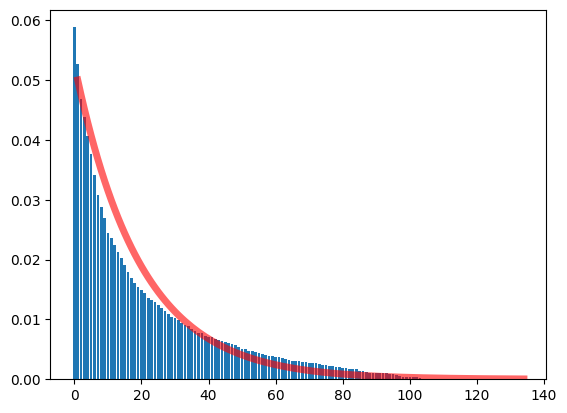

In [59]:
q = mc_df['target'] != mc_df['char']
__df = oc_df.reset_index()
plt.bar(__df.index.values, __df['count']/__df['count'].sum())
geom = stats.geom

p = .05 
x = np.arange(stats.geom.ppf(0.0001, p),
                stats.geom.ppf(0.999, p))
plt.plot(x, stats.geom.pmf(x, p), 'r-', lw=5, alpha=0.6, label='geom pdf')
plt.show()

In [65]:
mean = mc_df[mc_df['target'] != mc_df['char']]['count'].mean()
mean

10.776764282285166

In [64]:
lognorm = stats.lognorm.fit(mc_df[mc_df['target'] != mc_df['char']]['count'])
lognorm

(7.383119754985527, 0.9999999999999999, 0.5126480663579185)

### Profile Added Data

In [ ]:
prep_path = Path(os.environ['CORC_DATASETS_PREP_DIR'])
wiki_uncommon = pd.read_csv(prep_path/'legit-extended'/'wikitext-uncommon.csv')

In [62]:
added = datasets.Dataset.from_pandas(wiki_uncommon[['word', 'count']])
added

Dataset({
    features: ['word', 'count'],
    num_rows: 250
})